# Battle of Neighborhoods

### In pursuit of the the perfect place.

### Find the best Italian restaurants amongst the New York neighborhoods.

New York is famous for it's Italian population. Many Italian immigrants have come to New York to reside, bringing along with them their traditions and divine cousine. 

### Project Description:
The projects aim is to find the best Italian restaurants amongst the Neighborhoods of New York, and having chosen the 3 best ones based on their score and reviews on Foursquare, cluster the neighbourhoods around them using DBSCAN. With this algorithm we will be able to detect outliers, which in this case that we have spatial data, will be neighborhoods, and suggest possible neighborhoods for a new italian restaurant. 

### 1. Python Packages and Dependencies

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import random # library for random number generation

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

print('Folium installed')
print('Libraries imported.')

### 2. Data Loading 


Since the JSON file already exists on the server, we use the wget command to download the data.

In [35]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Now let's view the data.

In [36]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a look at the data, to decide which features we will use and put into a dataframe for further process.

In [4]:
newyork_data

{'bbox': [-74.2492599487305,
  40.5033187866211,
  -73.7061614990234,
  40.9105606079102],
 'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}, 'type': 'name'},
 'features': [{'geometry': {'coordinates': [-73.84720052054902,
     40.89470517661],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.1',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661],
    'borough': 'Bronx',
    'name': 'Wakefield',
    'stacked': 1},
   'type': 'Feature'},
  {'geometry': {'coordinates': [-73.82993910812398, 40.87429419303012],
    'type': 'Point'},
   'geometry_name': 'geom',
   'id': 'nyu_2451_34572.2',
   'properties': {'annoangle': 0.0,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.874294193

#### Transform the data into the proper DataFrame

The DataFrame we will construct has 3 columns : Name, Latitude, Longitude.
So each row of our dataframe will include every neighborhood of New York, with their respective coordinates. 

Let's construct the dataframe, and load the afforementioned data.

In [37]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [39]:
neighborhoods_data = newyork_data['features']

In [40]:
for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [41]:
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


In [9]:
neighborhoods.shape

(306, 3)

As we can see above, the dataframe 'neighborhoods' now contains the information we wanted, and we have a total of 306 neighborhoods.

#### Creating a Map of neighborhoods.

Now we can display a map with all the neighborhoods surrounding New York.

To do so, we will need to firstly get the coordinates of New York using the **geopy** library.

In [65]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [68]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{},'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
 
map_newyork

### 3. Foursquare search

Now that we have all the neighborhoods that we are interested in, we can move onto searching for Italian restaurants in each one of them.

Firstly we will define our credentials in order to be able to make calls to the API. Since this is sensitive information, it will be included in a hidden cell.

In [32]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: C3YERROVVM2LULTCIOFKSCWOQZDB15SPUM22XK0LGEARLE1C
CLIENT_SECRET:RRSAKA3OBNJNCCXI100SIVAWZYJOJCWEJYX5WLGB0QN3HI5M


Now we need to make our query, to search for Italian restaurants and loop through every neighborhood.

Firstly we will get all nearby venues for each neighborhood, and include their Name, Latitude, Longitude and Category in a new dataframe.

In [63]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue ID',
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

KeyError: 'groups'

In [56]:
ny_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,4bf58dd8d48988d1d0941735,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,4bf58dd8d48988d10f951735,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,4bf58dd8d48988d1c9941735,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,4bf58dd8d48988d144941735,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,4bf58dd8d48988d113951735,Gas Station


In [55]:
ny_venues.shape


(10368, 8)

In [59]:
ny = ny_venues.loc[ny_venues['Venue Category'] == 'Italian Restaurant']
ny = ny.reset_index(drop=True)

In [60]:
print(ny.shape)
ny.head()

(318, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category
0,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,40.900638,-73.867724,4bf58dd8d48988d110941735,Italian Restaurant
1,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,4bf58dd8d48988d110941735,Italian Restaurant
2,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,40.854788,-73.854929,4bf58dd8d48988d110941735,Italian Restaurant
3,City Island,40.847247,-73.786488,Artie's Steak and Seafood,40.849542,-73.787317,4bf58dd8d48988d110941735,Italian Restaurant
4,Throgs Neck,40.815109,-73.816350,Tosca Marquee,40.819222,-73.817601,4bf58dd8d48988d110941735,Italian Restaurant


We only choose the venues that are Italian restaurants and form the dataframe as such.

The next step is to iterate through all these restaurants and get their ratings.


In [27]:
def getRating(id):
    
    ratings = []
    for id in zip(id):
        print(id)
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(id, CLIENT_ID, CLIENT_SECRET, VERSION)

        result = requests.get(url).json()
        try:
            print(result['response']['venue']['rating'])
            ratings.append(result['response']['venue']['rating'])
        except:
            print('This venue has not been rated yet.')
        
    return(ratings)

### Process data 

After we have accumulated the information needed, we populate one dataframe with all information.

We will need to 'clean' the data before moving on to the next step.

In [11]:
df_data_1 = df_data_1.drop_duplicates(subset='Venue', keep="first")
df_data_1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Rating
0,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,40.900638,-73.867724,4bf58dd8d48988d110941735,Italian Restaurant,8.4
1,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,4bf58dd8d48988d110941735,Italian Restaurant,8.4
2,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,40.854788,-73.854929,4bf58dd8d48988d110941735,Italian Restaurant,7.5
3,City Island,40.847247,-73.786488,Artie's Steak and Seafood,40.849542,-73.787317,4bf58dd8d48988d110941735,Italian Restaurant,8.3
4,Throgs Neck,40.815109,-73.816350,Tosca Marquee,40.819222,-73.817601,4bf58dd8d48988d110941735,Italian Restaurant,7.2
5,Morris Park,40.847549,-73.850402,Patricia's,40.849313,-73.853536,4bf58dd8d48988d110941735,Italian Restaurant,8.7
6,Belmont,40.857277,-73.888452,Tino's Delicatessen,40.855882,-73.887166,4bf58dd8d48988d110941735,Italian Restaurant,9.2
7,Belmont,40.857277,-73.888452,Michaelangelo's Coal Fired Brick Oven Pizza Re...,40.857412,-73.886468,4bf58dd8d48988d110941735,Italian Restaurant,8.2
8,Belmont,40.857277,-73.888452,Calabria Pork Store,40.854145,-73.888776,4bf58dd8d48988d110941735,Italian Restaurant,8.8
9,Belmont,40.857277,-73.888452,Dominick's Restaurant,40.854215,-73.888765,4bf58dd8d48988d110941735,Italian Restaurant,8.4


In [12]:
df_data_1.dropna()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Rating
0,Woodlawn,40.898273,-73.867315,Patrizia's Of Woodlawn,40.900638,-73.867724,4bf58dd8d48988d110941735,Italian Restaurant,8.4
1,Pelham Parkway,40.857413,-73.854756,Enzo's,40.854232,-73.854362,4bf58dd8d48988d110941735,Italian Restaurant,8.4
2,Pelham Parkway,40.857413,-73.854756,Pasta Pasta,40.854788,-73.854929,4bf58dd8d48988d110941735,Italian Restaurant,7.5
3,City Island,40.847247,-73.786488,Artie's Steak and Seafood,40.849542,-73.787317,4bf58dd8d48988d110941735,Italian Restaurant,8.3
4,Throgs Neck,40.815109,-73.816350,Tosca Marquee,40.819222,-73.817601,4bf58dd8d48988d110941735,Italian Restaurant,7.2
5,Morris Park,40.847549,-73.850402,Patricia's,40.849313,-73.853536,4bf58dd8d48988d110941735,Italian Restaurant,8.7
6,Belmont,40.857277,-73.888452,Tino's Delicatessen,40.855882,-73.887166,4bf58dd8d48988d110941735,Italian Restaurant,9.2
7,Belmont,40.857277,-73.888452,Michaelangelo's Coal Fired Brick Oven Pizza Re...,40.857412,-73.886468,4bf58dd8d48988d110941735,Italian Restaurant,8.2
8,Belmont,40.857277,-73.888452,Calabria Pork Store,40.854145,-73.888776,4bf58dd8d48988d110941735,Italian Restaurant,8.8
9,Belmont,40.857277,-73.888452,Dominick's Restaurant,40.854215,-73.888765,4bf58dd8d48988d110941735,Italian Restaurant,8.4


In [42]:
df_data_1 = df_data_1.reset_index(drop=True)

In [25]:
df_data_1.shape

(281, 9)

In [20]:
df_data_1.dtypes

Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue ID                   object
Venue Category             object
Rating                     object
dtype: object

In [23]:
df_data_1 = df_data_1[df_data_1.Rating != 'no rating']

In [26]:
df_data_1["Rating"] = df_data_1.Rating.astype(float)

Now we can find the the Italian Restaurants with the top rating

In [44]:
df_data_1=df_data_1.sort_values(by=['Rating'],ascending=False)

In [45]:
df_data_1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue ID,Venue Category,Rating
0,Fort Greene,40.688527,-73.972906,Evelina Restaurant,40.689583,-73.971083,4bf58dd8d48988d110941735,Italian Restaurant,9.4
1,West Village,40.734434,-74.006180,L'Artusi,40.733888,-74.005114,4bf58dd8d48988d110941735,Italian Restaurant,9.4
2,Carroll Gardens,40.680540,-73.994654,Frankies 457 Spuntino,40.677360,-73.998047,4bf58dd8d48988d110941735,Italian Restaurant,9.3
3,West Village,40.734434,-74.006180,Via Carota,40.733052,-74.003573,4bf58dd8d48988d110941735,Italian Restaurant,9.3
4,Boerum Hill,40.685683,-73.983748,Rucola,40.685659,-73.985769,4bf58dd8d48988d110941735,Italian Restaurant,9.3
5,Tottenville,40.505334,-74.246569,Villaggio,40.509210,-74.246456,4bf58dd8d48988d110941735,Italian Restaurant,9.3
6,Little Italy,40.719324,-73.997305,Rubirosa Ristorante,40.722706,-73.995957,4bf58dd8d48988d110941735,Italian Restaurant,9.3
7,Greenwich Village,40.726933,-73.999914,Carbone,40.727903,-74.000136,4bf58dd8d48988d110941735,Italian Restaurant,9.2
8,Tribeca,40.721522,-74.010683,Locanda Verde,40.720090,-74.010405,4bf58dd8d48988d110941735,Italian Restaurant,9.2
9,Cobble Hill,40.687920,-73.998561,Lillo,40.690200,-73.996540,4bf58dd8d48988d110941735,Italian Restaurant,9.2


We choose the first 3 restaurants. The top 2 have the best rating of 9.4 and the third a rating of 9.3. 

We place them in a map.


In [ ]:
top_restaurants = pd.DataFrame()
top_restaurants = df_data_1.iloc[:3]

We now remove any unnecessary columns from our dataframe, in order to be able to aggragate the two dataframes. This will be helpful later on our cluster analysis.

In [ ]:
top_restaurants = top_restaurants.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue ID','Venue Category','Rating'], axis=1)
top_restaurants

In [59]:
top_restaurants = top_restaurants[['Venue Latitude', 'Venue Longitude', 'Venue']]
top_restaurants.columns = ['Latitude','Longitude','Neighborhood']
top_restaurants

,Latitude,Longitude,Neighborhood
0,40.689583,-73.971083,Evelina Restaurant
1,40.733888,-74.005114,L'Artusi
2,40.677360,-73.998047,Frankies 457 Spuntino


In [60]:
data = pd.DataFrame()
data = neighborhoods.append(top_restaurants)

In [62]:
data = data.reset_index(drop=True)

In [63]:
data

,Latitude,Longitude,Neighborhood
0,40.894705,-73.847201,Wakefield
1,40.874294,-73.829939,Co-op City
2,40.887556,-73.827806,Eastchester
3,40.895437,-73.905643,Fieldston
4,40.890834,-73.912585,Riverdale
5,40.881687,-73.902818,Kingsbridge
6,40.876551,-73.910660,Marble Hill
7,40.898273,-73.867315,Woodlawn
8,40.877224,-73.879391,Norwood
9,40.881039,-73.857446,Williamsbridge


#### Plotting the top rated restaurants and neighborhoods.

In [69]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{},'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  

for lat, lng, neighborhood in zip(top_restaurants['Latitude'], top_restaurants['Longitude'], top_restaurants['Neighborhood']):
    label = '{},'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
map_newyork

### 4. DBSCAN Analysis

In this section we perform the DBSCAN Analusis on the data.

We tweak the parameters of the algoritm, and we then visualize the findings. Each different color represents a cluster, and the blue colored marks represent the outliers.

Text(0,0.5,'Feature 1')

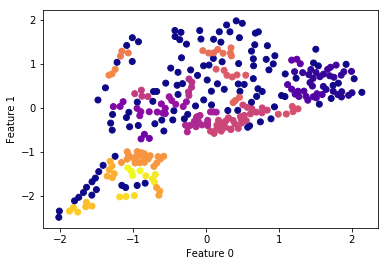

In [91]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[['Latitude','Longitude']])

# cluster the data into five clusters
dbscan = DBSCAN(eps=0.123, min_samples = 2.5)
clusters = dbscan.fit_predict(X_scaled)

# plot the cluster assignments
import matplotlib.pyplot as plt
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### 5. Conclusion

From the findings of the analysis we can provide the business man with information as to which neighbourhood is a possible candidate for building an Italian restaurant. We come to this conclusion as we can see from the final plot that the clusters form very close to the marks on the map that are the top rated restaurants.